## Importing the dependencies

In [1]:
import numpy as np
import pandas as pd
from glob import glob 
from tqdm import tqdm
import seaborn as sns




from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, classification_report, confusion_matrix
from datetime import datetime, timedelta
import h5py
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy import stats, signal

import obspy
from obspy.geodetics.base import gps2dist_azimuth
from obspy.clients.fdsn import Client
import time
pd.set_option('display.max_columns', None)
from joblib import dump, load
from obspy.signal.filter import envelope
import tsfel

import sys
sys.path.append('../feature_extraction_scripts/physical_feature_extraction_scripts')
import seis_feature

sys.path.append('../src')

from tsfel import time_series_features_extractor, get_features_by_domain
import os

from utils import apply_cosine_taper, butterworth_filter, plot_confusion_matrix, plot_classification_report, calculate_distance

import pickle
from zenodo_get import zenodo_get
import matplotlib.cm as cm



## Now in the next cells, we have to specify a filename. 

We can specify one out of three filenames. The filenames follow the format - 'P_before_after_F_lowcut_highcut_sampling_rate'
So the above name refer to the waveforms that started "origin time/first arrival pick - before" and ended at "origin time/first arrival pick + after", were bandpass filtered into "(lowcut, highcut)" filter and resampled to "sampling rate" before extracting features. 

We have a choice to choose among three filenames - 

- "P_10_30_F_1_15_50"
- "P_10_100_F_1_10_50"
- "P_50_100_F_1_10_50"

### Specifying the filename

In [2]:
filename = 'P_10_30_F_1_15_50'

## Downloading physical and tsfel features stored on a zenodo repository for a given filename

In [6]:
if filename == 'P_10_30_F_1_15_50':
    doi = '10.5281/zenodo.12690691'
    
elif filename == 'P_10_100_F_1_10_50':
    doi = '10.5281/zenodo.12689933'
    
elif filename == 'P_50_100_F_1_10_50':
    doi = '10.5281/zenodo.12689336'

In [7]:
## This is going to download all the feature files in current directory. Make sure we delete them after storing
files = zenodo_get([doi])

Title: Physical and Tsfel Features for 40s Waveforms
Keywords: 
Publication date: 2024-07-08
DOI: 10.5281/zenodo.12690692
Total size: 1615.9 MB

Link: https://zenodo.org/record/12690692/files/physical_features_earthquake_P_10_30_F_1_15_50_part_2.csv   size: 33.3 MB

Checksum is correct. (197fb2e4f10511c440667e35cd7c3d83)

Link: https://zenodo.org/record/12690692/files/physical_features_earthquake_P_10_30_F_1_15_50_part_3.csv   size: 33.8 MB

Checksum is correct. (b76e38f1c31b93ebe4b8e1a252f4fa4b)

Link: https://zenodo.org/record/12690692/files/tsfel_features_earthquake_P_10_30_F_1_15_50_part_3.csv   size: 295.5 MB

Checksum is correct. (7954810ba0e212aec4e7f69e23610d3f)

Link: https://zenodo.org/record/12690692/files/tsfel_features_surface event_P_10_30_F_1_15_50_part_1.csv   size: 53.6 MB

Checksum is correct. (0bf641eb7ea10159f2f946aad405fbdb)

Link: https://zenodo.org/record/12690692/files/tsfel_features_explosion_P_10_30_F_1_15_50_part_1.csv   size: 94.8 MB

Checksum is correct. (1

## Loading tsfel features

In [8]:
# These waveforms are filtered between 1-10 Hz
# extracting features of surface events, thunder and sonic booms
features_exotic_tsfel = pd.read_csv('tsfel_features_surface event_'+filename+'_part_1.csv')




# features of noise
features_noise_tsfel = pd.read_csv('tsfel_features_noise_'+filename+'_part_1.csv')



# features of explosion
features_explosion_tsfel = pd.read_csv('tsfel_features_explosion_'+filename+'_part_1.csv')



# features of earthquake (had to extract it in three parts because of memory constraints)
features_eq1 = pd.read_csv('tsfel_features_earthquake_'+filename+'_part_1.csv')
features_eq2 = pd.read_csv('tsfel_features_earthquake_'+filename+'_part_2.csv')
features_eq3 = pd.read_csv('tsfel_features_earthquake_'+filename+'_part_3.csv')
features_eq4 = pd.read_csv('tsfel_features_earthquake_'+filename+'_part_4.csv')



# features of earthquakes
features_earthquake_tsfel = pd.concat([features_eq1, features_eq2, features_eq3, features_eq4])

## Loading physical features

In [27]:
# extracting features of surface events, thunder and sonic booms
features_exotic_physical = pd.read_csv('physical_features_surface event_'+filename+'_part_1.csv', index_col=0)

features_surface_physical = features_exotic_physical[features_exotic_physical['source'] == 'surface event']
features_sonic_physical = features_exotic_physical[features_exotic_physical['source'] == 'sonic']
features_thunder_physical = features_exotic_physical[features_exotic_physical['source'] == 'thunder']



# features of noise
features_noise_physical = pd.read_csv('physical_features_noise_'+filename+'_part_1.csv', index_col=0)


# features of explosion
features_explosion_physical = pd.read_csv('physical_features_explosion_'+filename+'_part_1.csv', index_col=0)

# features of earthquakes
features_eq1 = pd.read_csv('physical_features_earthquake_'+filename+'_part_1.csv', index_col=0)
features_eq2 = pd.read_csv('physical_features_earthquake_'+filename+'_part_2.csv', index_col=0)
features_eq3 = pd.read_csv('physical_features_earthquake_'+filename+'_part_3.csv', index_col=0)
features_eq4 = pd.read_csv('physical_features_earthquake_'+filename+'_part_4.csv', index_col=0)

features_earthquake_physical = pd.concat([features_eq1, features_eq2, features_eq3, features_eq4])

## Merging tsfel + physical features

In [10]:
features_noise = pd.merge(features_noise_physical, features_noise_tsfel, on = ['serial_no', 'source'])
features_earthquake = pd.merge(features_earthquake_physical, features_earthquake_tsfel, on = ['serial_no', 'source'])
features_explosion = pd.merge(features_explosion_physical, features_explosion_tsfel, on = ['serial_no', 'source'])


features_surface_tsfel = features_exotic_tsfel[features_exotic_tsfel['source'] == 'surface event']
features_sonic_tsfel = features_exotic_tsfel[features_exotic_tsfel['source'] == 'sonic']
features_thunder_tsfel = features_exotic_tsfel[features_exotic_tsfel['source'] == 'thunder']

features_surface_physical = features_exotic_physical[features_exotic_physical['source'] == 'surface event']
features_sonic_physical = features_exotic_physical[features_exotic_physical['source'] == 'sonic']
features_thunder_physical = features_exotic_physical[features_exotic_physical['source'] == 'thunder']


features_surface = pd.merge(features_surface_physical, features_surface_tsfel, on = ['serial_no', 'source'])
features_sonic = pd.merge(features_sonic_physical, features_sonic_tsfel, on = ['serial_no', 'source'])
features_thunder = pd.merge(features_thunder_physical, features_thunder_tsfel, on = ['serial_no', 'source'])



features_all = pd.concat([features_surface, features_sonic, features_thunder, features_noise, features_explosion, features_earthquake])

In [11]:
tsfel_features = features_exotic_tsfel.columns[:-2]
physical_features = features_exotic_physical.columns[:-2]
final_features_list = np.concatenate([tsfel_features,physical_features,['source', 'serial_no']])

features_all = features_all.loc[:, final_features_list]
print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')

So we have 230373 events and each event have 454 features


## Preprocessing the input features

## 1. Removing highly correlated features
Highly correlated features carry redundant information. This redundancy does not add any new information to the model but can lead to overfitting. Overfitting occurs when the model learns the noise in the training data rather than the actual signal, which reduces its generalizability to new data. So first, we will identify the features that are highly correlated to each other (cc > 0.95) and only select one of these features.

In [12]:
serial_nos = features_all['serial_no'].values
features_all = features_all.drop(['Unnamed: 0_x','Unnamed: 0_y', 'source_x', 'serial_no'], axis = 1, errors = 'ignore')
features_all.rename(columns={'source_y': 'source'}, inplace=True)


corr_features = tsfel.correlated_features(features_all.drop(['source'], axis = 1))

features_all.drop(corr_features, axis=1, inplace=True)
features_all['serial_no'] = serial_nos
print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')

So we have 230373 events and each event have 383 features


## 2. Dropping all the columns that contains infinity or nan values for any event. 
Many statistical operations, such as calculating means, variances, and covariances, do not work properly with NaN or infinity values. This can lead to incorrect parameter estimates and unreliable statistical inferences.

In [13]:
# dropping the columns that contain NaNs
features_all = features_all.dropna(axis = 1)

# dropping the rows that contains NaNs
features_all = features_all.dropna()


## dropping all the rows containing infinity values
features_all = features_all.replace([np.inf, -np.inf], np.nan).dropna()


## dropping sonic boom and thunder events
features_all = features_all[features_all['source'] != 'sonic']
features_all = features_all[features_all['source'] != 'thunder']

print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')


So we have 229149 events and each event have 382 features


## 3. Removing the features that have the same values for all the features. 
It is important to remove such features since they are not actually contributing in anything but are unnecessarily increasing the computational time. 

In [14]:
# Check unique values in each column
unique_counts = features_all.nunique()

# Identify columns with only one unique value (same value for all rows)
single_value_columns = unique_counts[unique_counts == 1].index


# Drop columns with the same value for all rows
features_all = features_all.drop(columns=single_value_columns)

print(f'So we have {features_all.shape[0]} events and each event have {features_all.shape[1]} features')


So we have 229149 events and each event have 366 features


## 4. Removing the outliers based on z-score
Only retaining those events that have the values of all their features lying with 4 times of standard deviations for each features. 

In [15]:
df = features_all.drop(['serial_no', 'source'], axis = 1)
# Calculate Z-scores for each feature
z_scores = np.abs(stats.zscore(df))


# Define a threshold for Z-score beyond which data points are considered outliers
threshold = 10

# Filter out rows with any Z-score greater than the threshold
# Temporarily removing this 
outliers_removed_df =   features_all[(z_scores < threshold).all(axis=1)]

print(f'So we have {outliers_removed_df.shape[0]} events and each event have {outliers_removed_df.shape[1]} features')


So we have 208476 events and each event have 366 features


## Plotting histogram before and after removing the outliers

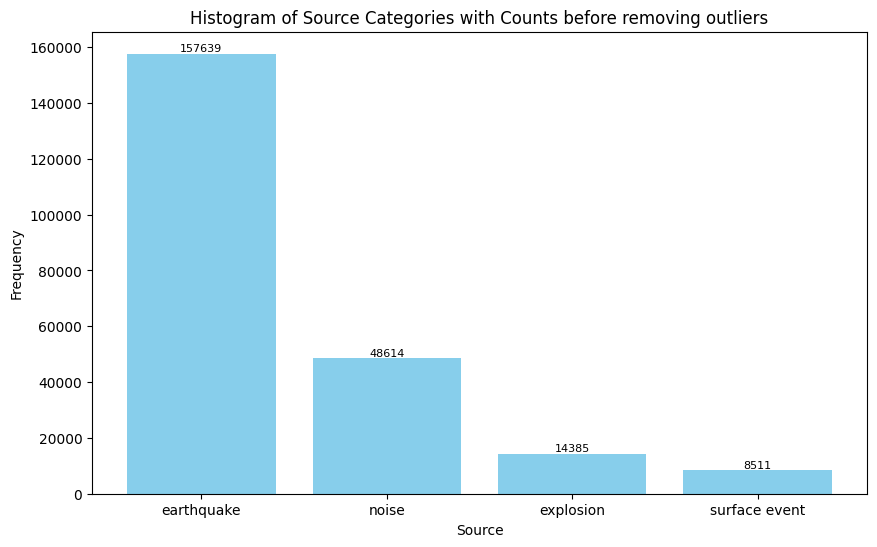

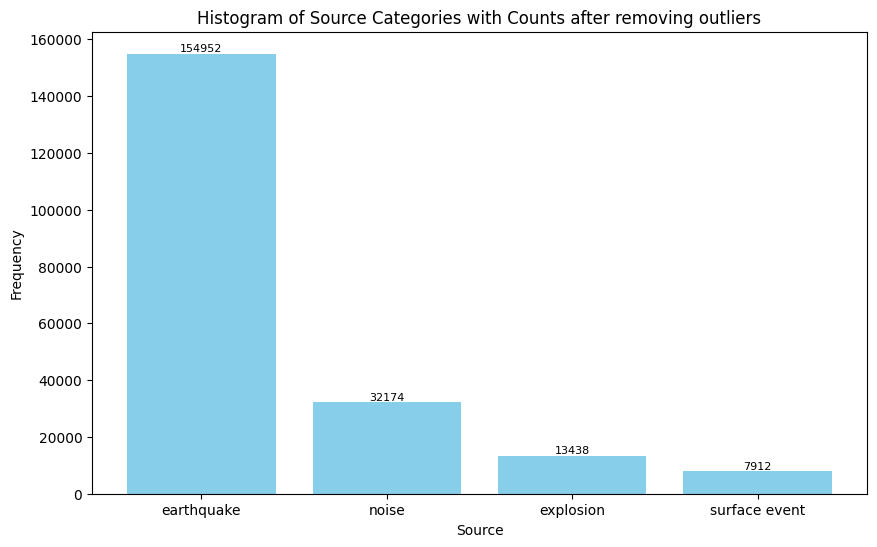

In [16]:
# Assuming 'source' is a categorical column in your DataFrame
categories, counts = features_all['source'].value_counts().index, features_all['source'].value_counts().values

plt.figure(figsize=(10, 6))

# Plot the histogram
plt.bar(categories, counts, color='skyblue')

# Add text annotations on top of each bar
for i, count in enumerate(counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=8, color='black')

plt.xlabel('Source')
plt.ylabel('Frequency')
plt.title('Histogram of Source Categories with Counts before removing outliers')

plt.show()




# Assuming 'source' is a categorical column in your DataFrame
categories, counts = outliers_removed_df['source'].value_counts().index, outliers_removed_df['source'].value_counts().values

plt.figure(figsize=(10, 6))

# Plot the histogram
plt.bar(categories, counts, color='skyblue')

# Add text annotations on top of each bar
for i, count in enumerate(counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom', fontsize=8, color='black')

plt.xlabel('Source')
plt.ylabel('Frequency')
plt.title('Histogram of Source Categories with Counts after removing outliers')

plt.show()


## Standardizing the features

In [17]:
## defining the global variables X and y
X = outliers_removed_df.drop(['serial_no','source'], axis = 1)
y = outliers_removed_df['source']


# Initialize the StandardScaler
scaler = StandardScaler()



# Apply standard scaling to the DataFrame
scaled_features = scaler.fit_transform(X)


# Access the mean and standard deviation for each feature
means = scaler.mean_
std_devs = scaler.scale_

# Create a DataFrame to display the means and standard deviations
scaler_params = pd.DataFrame({'Feature': X.columns, 'Mean': means, 'Std Dev': std_devs})
print(scaler_params)


# Create a new DataFrame with scaled features
X_scaled = pd.DataFrame(scaled_features, columns=X.columns)


## We are not standardizing at this stage. We will rather wait when the outlier are removed, then we will
## standardize and save the standard scaler parameters. 
#X_scaled = X

X_scaled['serial_no'] = outliers_removed_df['serial_no'].values
X_scaled['source'] = outliers_removed_df['source'].values

                      Feature       Mean    Std Dev
0    0_FFT mean coefficient_0   0.000030   0.000097
1    0_FFT mean coefficient_1   0.000010   0.000054
2    0_FFT mean coefficient_2   0.000045   0.000268
3    0_FFT mean coefficient_3   0.000129   0.000749
4    0_FFT mean coefficient_4   0.000289   0.001668
..                        ...        ...        ...
359                 Kurto_1_3   8.000209   9.953103
360                    E_3_10   0.468914   0.280435
361                Kurto_3_10  23.141946  26.635609
362                   E_10_20   0.153554   0.320194
363               Kurto_10_20  28.264564  37.592150

[364 rows x 3 columns]


## Merging the metadata information with extracted features to retreive their SNR

In [18]:
# extracting the stored data
comcat_file_name = h5py.File("/data/whd01/yiyu_data/PNWML/comcat_waveforms.hdf5",'r')
exotic_file_name = h5py.File("/data/whd01/yiyu_data/PNWML/exotic_waveforms.hdf5",'r')
noise_file_name = h5py.File("/data/whd01/yiyu_data/PNWML/noise_waveforms.hdf5",'r')


# extracting the catalog
comcat_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/comcat_metadata.csv")
exotic_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/exotic_metadata.csv")
noise_file_csv = pd.read_csv("/data/whd01/yiyu_data/PNWML/noise_metadata.csv")



# extracting the metadata corresponding to individual events
cat_exp = comcat_file_csv[comcat_file_csv['source_type'] == 'explosion']
cat_eq = comcat_file_csv[comcat_file_csv['source_type'] == 'earthquake']
cat_no = noise_file_csv
cat_su = exotic_file_csv[exotic_file_csv['source_type'] == 'surface event']



# extracting the index 
ind_exp = X_scaled[X_scaled['source'] == 'explosion']['serial_no'].values
ind_eq = X_scaled[X_scaled['source'] == 'earthquake']['serial_no'].values
ind_no = X_scaled[X_scaled['source'] == 'noise']['serial_no'].values
ind_su = X_scaled[X_scaled['source'] == 'surface event']['serial_no'].values


df_exp = X_scaled[X_scaled['source'] == 'explosion']
exp_df = cat_exp.iloc[ind_exp]
exp_df['serial_no'] = ind_exp


df_eq = X_scaled[X_scaled['source'] == 'earthquake']
eq_df = cat_eq.iloc[ind_eq]
eq_df['serial_no'] = ind_eq



df_no = X_scaled[X_scaled['source'] == 'noise']
no_df = cat_no.iloc[ind_no]
no_df['serial_no'] = ind_no



df_su = X_scaled[X_scaled['source'] == 'surface event']
su_df = cat_su.iloc[ind_su]
su_df['serial_no'] = ind_su





new_exp = pd.merge(df_exp,exp_df, on = 'serial_no')
new_eq = pd.merge(df_eq,eq_df, on = 'serial_no')
new_su = pd.merge(df_su,su_df, on = 'serial_no')
new_no = pd.merge(df_no,no_df, on = 'serial_no')
new_no['event_id'] = np.array(['noise'+str(i) for i in np.arange(len(new_no))])



X_final = pd.concat([new_exp, new_eq, new_su, new_no])
y = ['explosion']*len(new_exp)+['earthquake']*len(new_eq)+['surface']*len(new_su)+['noise']*len(new_no)



/home/ak287/miniconda3/envs/surface/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [19]:
# new_exp contains the features and the corresponding metadata information. 
datetimes = X_final['trace_start_time'].values

hour_of_day = []
days_of_week = []
month_of_year = []
for dt_str in tqdm(datetimes):
        
    # Parse the datetime string
        dt = datetime.strptime(dt_str, '%Y-%m-%dT%H:%M:%S.%fZ')
        hod = dt.hour - 8.  # converting to local time. 
        moy = dt.month
        
        
        days_of_week.append(dt.weekday())
        hour_of_day.append(hod)
        month_of_year.append(moy)
        
X_final['hour_of_day'] = hour_of_day
X_final['day_of_week'] = days_of_week
X_final['month_of_year'] = month_of_year


100%|██████████| 208476/208476 [00:01<00:00, 125992.20it/s]


## Performance variation with SNR

In [20]:
X_final_exp = X_final[X_final['source_type'] == 'explosion']
X_final_eq = X_final[X_final['source_type'] == 'earthquake']
X_final_no = X_final[X_final['source_type'] == 'noise']
X_final_su = X_final[X_final['source_type'] == 'surface event']



X_final_su['snr_z'] = [float(X_final_su['trace_snr_db'].values[i].split('|')[-1]) for i in range(len(X_final_su))]
X_final_eq['snr_z'] = [float(X_final_eq['trace_snr_db'].values[i].split('|')[-1]) for i in range(len(X_final_eq))]
X_final_exp['snr_z'] = [float(X_final_exp['trace_snr_db'].values[i].split('|')[-1]) for i in range(len(X_final_exp))]
X_final_no['snr_z'] = 50*np.ones(len(X_final_no))


new_X_final = pd.concat([X_final_eq, X_final_exp, X_final_su, X_final_no])
new_y = ['earthquake']*len(X_final_eq)+['explosion']*len(X_final_exp)+['surface']*len(X_final_su)+['noise']*len(X_final_no)


new_X_final['new_source']  = new_y



## Plotting the No. of events v/s SNR

In [21]:
snr_thresh = np.arange(20)
no_of_su = []
no_of_eq = []
no_of_exp = []


for i in range(len(snr_thresh)):
    no_of_su.append(len(np.unique(X_final_su[X_final_su['snr_z'] > snr_thresh[i]]['event_id'])))
    no_of_eq.append(len(np.unique(X_final_eq[X_final_eq['snr_z'] > snr_thresh[i]]['event_id'])))
    no_of_exp.append(len(np.unique(X_final_exp[X_final_exp['snr_z'] > snr_thresh[i]]['event_id'])))

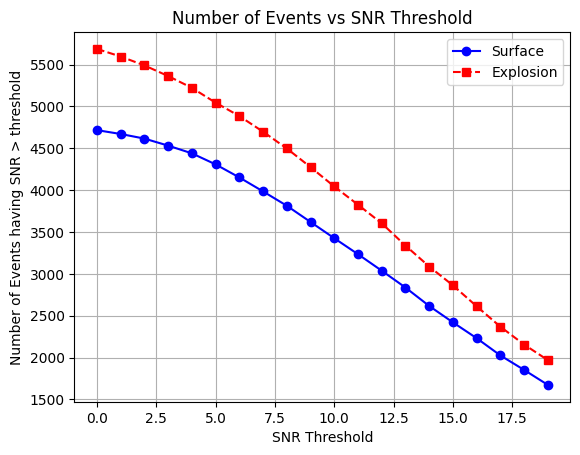

In [22]:
# Plotting Surface Events
plt.plot(snr_thresh, no_of_su, marker='o', linestyle='-', color='b', label='Surface')

# Plotting Explosion Events
plt.plot(snr_thresh, no_of_exp, marker='s', linestyle='--', color='r', label='Explosion')

# Adding labels and title
plt.ylabel('Number of Events having SNR > threshold')
plt.xlabel('SNR Threshold')
plt.title('Number of Events vs SNR Threshold')

# Adding legend
plt.legend()

# Adding grid lines
plt.grid(True)

# Display the plot
plt.show()


## Plotting the performance with SNR


In the following section, I am going to train the model with 3000 traces per class having a SNR > threshold and test it on randomly selected 2000 events per class covering all the SNR. I am going to plot a graph of weighted F1-score vs SNR, SNR distribution in test and train data for each iteration, and Confusion matrix and classification report for each iteration

  0%|          | 0/5 [00:00<?, ?it/s]

SNR 2.0


 20%|██        | 1/5 [00:24<01:37, 24.42s/it]

SNR 4.0


 40%|████      | 2/5 [00:48<01:12, 24.27s/it]

SNR 6.0


 60%|██████    | 3/5 [01:13<00:48, 24.42s/it]

SNR 8.0


 80%|████████  | 4/5 [01:38<00:24, 24.62s/it]

SNR 10.0


100%|██████████| 5/5 [02:02<00:00, 24.58s/it]


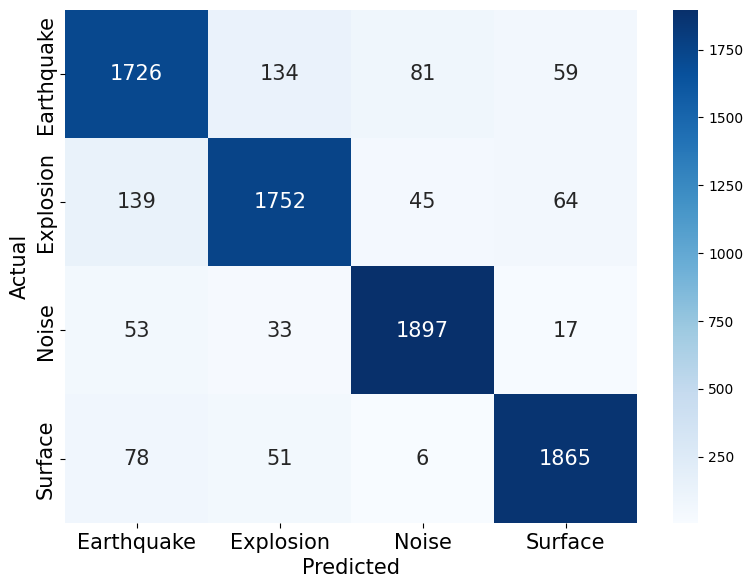

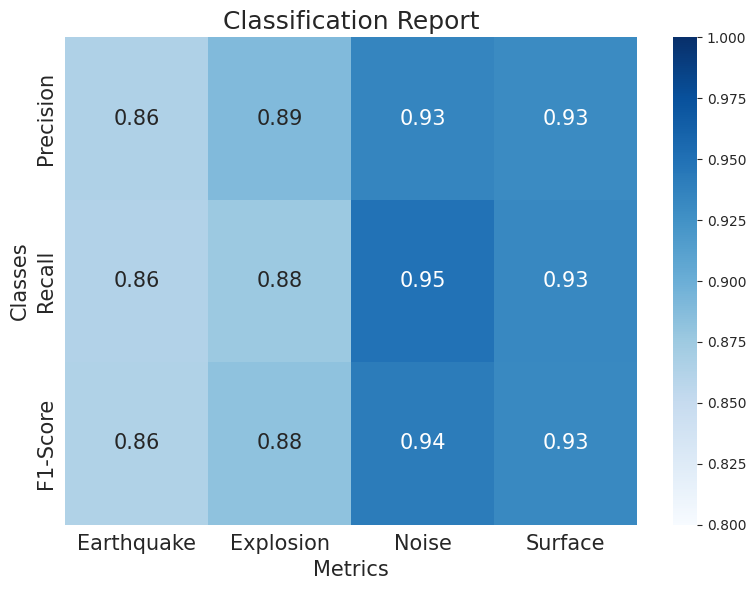

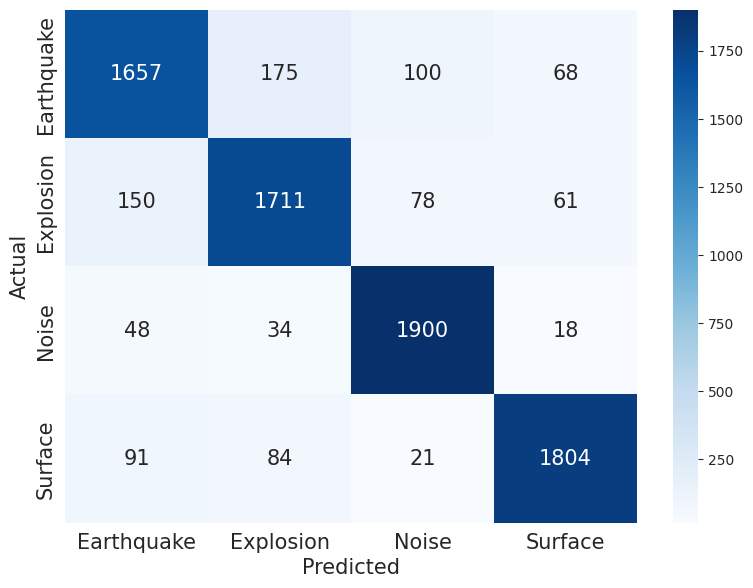

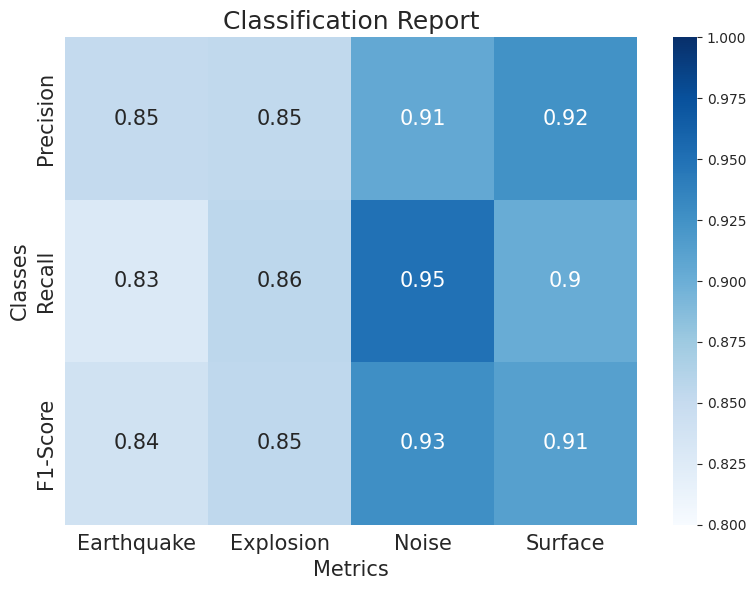

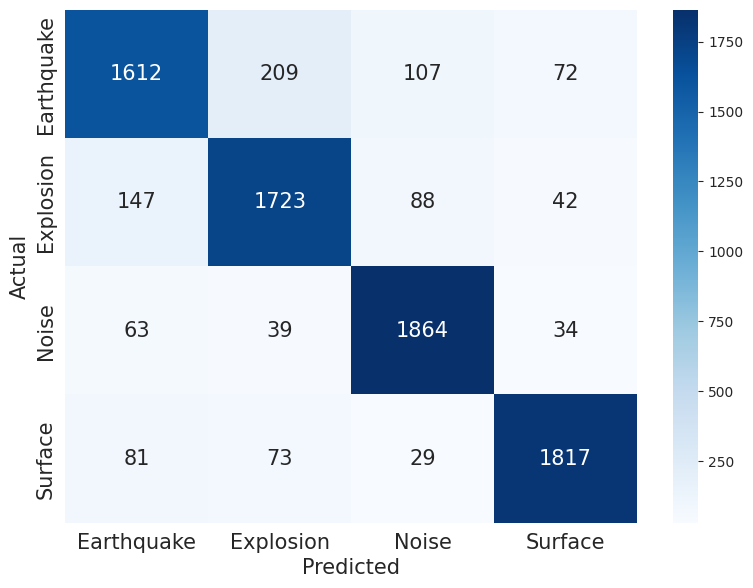

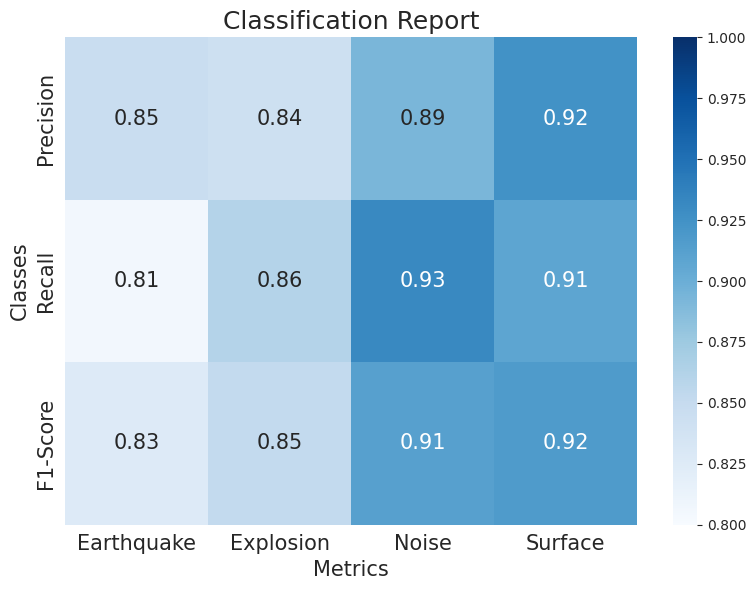

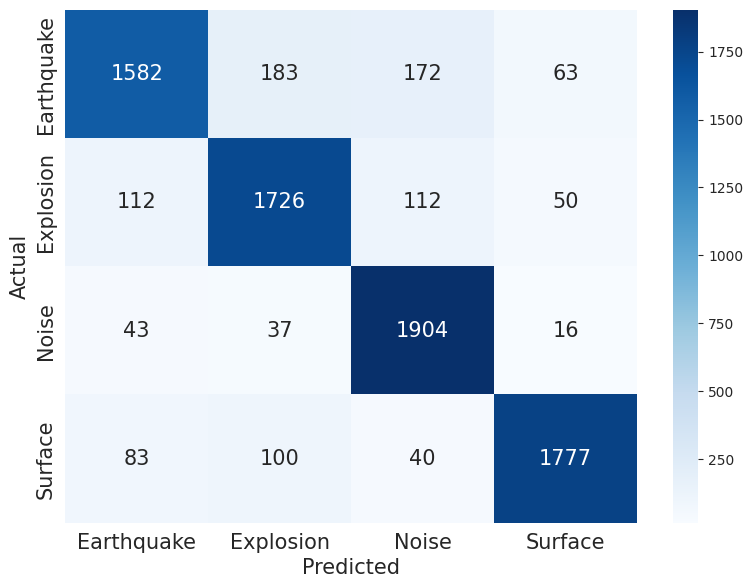

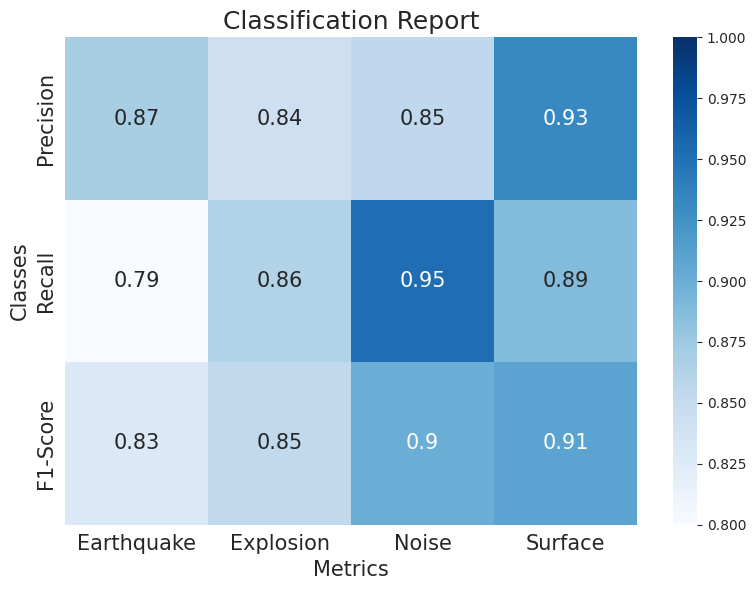

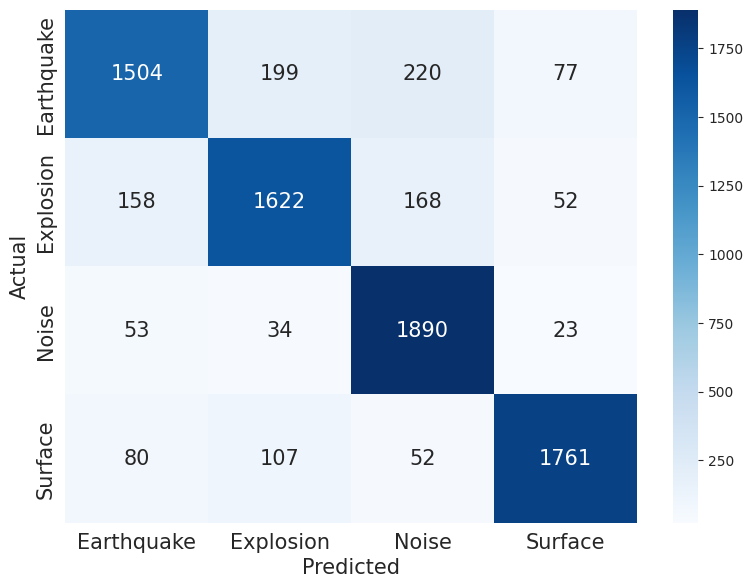

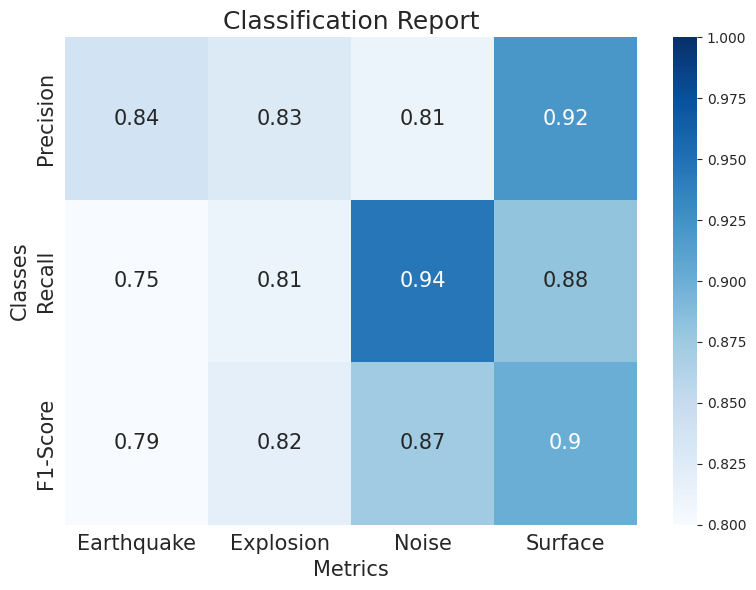

In [23]:
snr_test_thresh = np.linspace(2, 10, 5)
crs = []

for i in tqdm(range(len(snr_test_thresh))):

    new_X_final = pd.concat([X_final_eq, X_final_exp, X_final_su, X_final_no])
    new_y = ['earthquake']*len(X_final_eq)+['explosion']*len(X_final_exp)+['surface']*len(X_final_su)+['noise']*len(X_final_no)


    new_X_final['new_source']  = new_y
    new_X_final.index = new_X_final['event_id']




    ## grabbing all the events with SNR greater than threshold
    train_X_final = new_X_final[new_X_final['snr_z'] > snr_test_thresh[i]]

    ## only selecting the relevant columns as features. 
    train_X = train_X_final.iloc[:, 0:int(np.where(train_X_final.columns == 'serial_no')[0])]

    ## adding hod, dow, moy
    train_X = train_X.assign(hod= train_X_final['hour_of_day'].values, dow= train_X_final['day_of_week'].values, moy= train_X_final['month_of_year'].values)

    ## extracting the source columns
    train_y = train_X_final['new_source'].values




    # Apply random undersampling using imbalanced-learn library
    rus = RandomUnderSampler(sampling_strategy={'earthquake':3000, 'explosion':3000, 'surface':3000, 'noise':3000}, random_state=42)
    X_resampled_train, y_resampled_train = rus.fit_resample(train_X, train_y)

    # Reassign the indices to the resampled data
    X_resampled_train.index = train_X.index[rus.sample_indices_]

    # Initialize the LabelEncoder
    label_encoder = LabelEncoder()
    y_num_train = label_encoder.fit_transform(y_resampled_train)




    ## selecting all the events that are not in the training dataset so it will be a mix of snrs. 
    test_X_final = new_X_final.loc[~new_X_final.index.isin(X_resampled_train.index)]


    ## only selecting the relevant columns as features. 
    test_X = test_X_final.iloc[:, 0:int(np.where(test_X_final.columns == 'serial_no')[0])]

    ## adding hod, dow, moy
    test_X = test_X.assign(hod= test_X_final['hour_of_day'].values, dow= test_X_final['day_of_week'].values, moy= test_X_final['month_of_year'].values)
    test_y = test_X_final['new_source'].values

    # Apply random undersampling using imbalanced-learn library
    rus = RandomUnderSampler(sampling_strategy={'earthquake':2000, 'explosion':2000, 'surface':2000, 'noise':2000}, random_state=42)

    X_resampled_test, y_resampled_test = rus.fit_resample(test_X, test_y)

    # Reassign the indices to the resampled data
    X_resampled_test.index = test_X.index[rus.sample_indices_]




    # Initialize the LabelEncoder
    label_encoder = LabelEncoder()

    # Fit the LabelEncoder on the text labels and transform them to numeric labels
    y_num_test = label_encoder.fit_transform(y_resampled_test)




    # Initialize the Random Forest model
    rf_model = RandomForestClassifier(random_state=42)


    rf_model.fit(X_resampled_train, y_num_train)


    y_pred_test = rf_model.predict(X_resampled_test)

    
    
    print(f'SNR {snr_test_thresh[i]}')

    ## plotting confusion matrix
    cm = confusion_matrix(y_num_test, y_pred_test)
    plot_confusion_matrix(cm, figure_name = '../figures/confusion_matrix_'+filename+'_snr_'+str(snr_test_thresh[i])+'.png')


    cr = classification_report(y_num_test, y_pred_test, output_dict = True)
    plot_classification_report(cr, figure_name = '../figures/classification_report_'+filename+'_snr_'+str(snr_test_thresh[i])+'.png')

    crs.append(cr)



In [24]:
eq_f1 = [crs[i]['0']['f1-score'] for i in range(len(crs))]
exp_f1 = [crs[i]['1']['f1-score'] for i in range(len(crs))]
no_f1 = [crs[i]['2']['f1-score'] for i in range(len(crs))]
su_f1 = [crs[i]['3']['f1-score'] for i in range(len(crs))]


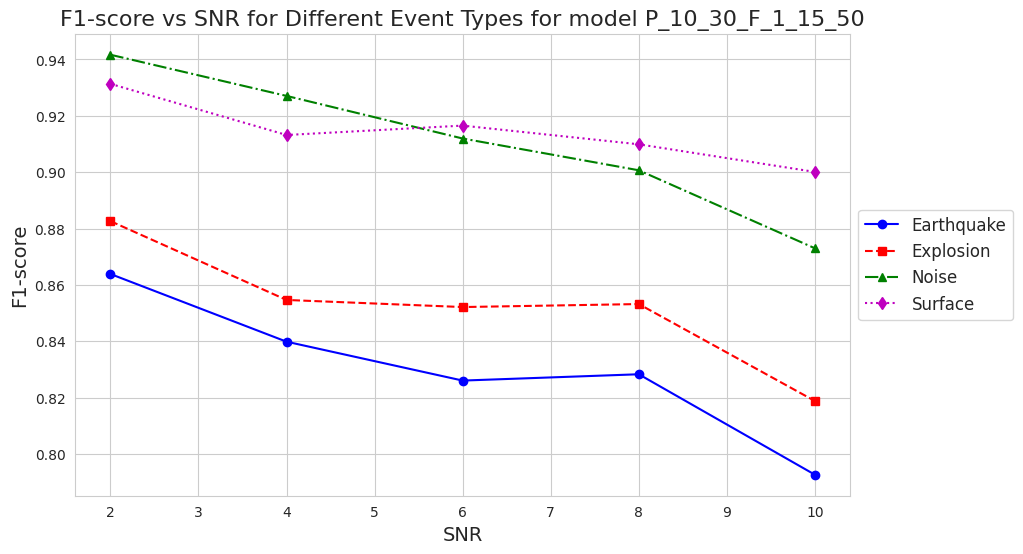

In [25]:
# Plotting
plt.figure(figsize=(10, 6))

plt.plot(snr_test_thresh, eq_f1, marker='o', linestyle='-', color='b', label='Earthquake')
plt.plot(snr_test_thresh, exp_f1, marker='s', linestyle='--', color='r', label='Explosion')
plt.plot(snr_test_thresh, no_f1, marker='^', linestyle='-.', color='g', label='Noise')
plt.plot(snr_test_thresh, su_f1, marker='d', linestyle=':', color='m', label='Surface')

plt.ylabel('F1-score', fontsize=14)
plt.xlabel('SNR', fontsize=14)

plt.title('F1-score vs SNR for Different Event Types for model '+filename, fontsize=16)
plt.grid(True)

# Improve legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)

plt.savefig(f'../figures/F1_score_snr_{filename}.png', dpi=300, bbox_inches='tight')

# Show plot
plt.show()

## Deleting the downloaded feature files

In [26]:
# Get the current working directory
directory = os.getcwd()

# List the files in the directory
files = os.listdir(directory)

# Iterate over the files and delete CSV files
for file in files:
    if file.endswith(".csv"):
        file_path = os.path.join(directory, file)
        os.remove(file_path)